# Fine-Tuning GPT for Personalized Recipe Recommendation and Generating Visualizations with GANs

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch

## 1. Data Preprocessing and Analysis

Dataset link: [Food.com - Recipes and Reviews](https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews)

### Loading the Datasets

In [117]:
# Load the datasets
recipes_df = pd.read_csv('Datasets/recipes.csv')
reviews_df = pd.read_csv('Datasets/reviews.csv')

### Exploratory Data Analysis (EDA)

In [118]:
# Basic Information
print("Recipes Dataframe:")
print(recipes_df.info())
print("\nReviews Dataframe:")
print(reviews_df.info())

Recipes Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   AuthorName                  522517 non-null  object 
 4   CookTime                    439972 non-null  object 
 5   PrepTime                    522517 non-null  object 
 6   TotalTime                   522517 non-null  object 
 7   DatePublished               522517 non-null  object 
 8   Description                 522512 non-null  object 
 9   Images                      522516 non-null  object 
 10  RecipeCategory              521766 non-null  object 
 11  Keywords                    505280 non-null  object 
 12  RecipeIngredientQuantities  522514 non-null  object 


In [119]:
# Quick look at the data
recipes_df.head()

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",...,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil..."


In [120]:
# Quick look at the data
reviews_df.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z


In [121]:
print("Missing values in Recipes Dataset:")
missing_values_recipes = recipes_df.isnull().sum()
print(missing_values_recipes[missing_values_recipes > 0])

print("\nMissing values in Reviews Dataset:")
missing_values_reviews = reviews_df.isnull().sum()
print(missing_values_reviews[missing_values_reviews > 0])

Missing values in Recipes Dataset:
CookTime                       82545
Description                        5
Images                             1
RecipeCategory                   751
Keywords                       17237
RecipeIngredientQuantities         3
AggregatedRating              253223
ReviewCount                   247489
RecipeServings                182911
RecipeYield                   348071
dtype: int64

Missing values in Reviews Dataset:
Review    214
dtype: int64


### Data Cleaning

In [122]:
# Parsing Time Duration Strings
import re

def parse_duration(duration_str):
    if pd.isnull(duration_str):
        return None  # Return None if input is NaN
    hours = minutes = 0
    hours_match = re.search(r'(\d+)H', duration_str)
    minutes_match = re.search(r'(\d+)M', duration_str)
    if hours_match:
        hours = int(hours_match.group(1))
    if minutes_match:
        minutes = int(minutes_match.group(1))
    return hours * 60 + minutes  # Convert to minutes

In [123]:
print(parse_duration('PT24H45M'))

1485


In [124]:
recipes_df['CookTimeMin'] = recipes_df['CookTime'].apply(parse_duration)
recipes_df['PrepTimeMin'] = recipes_df['PrepTime'].apply(parse_duration)
recipes_df['TotalTimeMin'] = recipes_df['TotalTime'].apply(parse_duration)
recipes_df.drop(['CookTime', 'PrepTime', 'TotalTime'], axis=1, inplace=True)

In [125]:
# Recipes Dataset Handling

# Impute 'CookTime' with median (or mean, based on your preference)
cook_time_median = recipes_df['CookTimeMin'].median()
recipes_df['CookTimeMin'].fillna(cook_time_median, inplace=True)

# Drop rows where 'Description' and 'Keywords' are missing - adjust based on your needs
recipes_df.dropna(subset=['Description', 'Keywords'], inplace=True)

# Assign 'Other' to missing 'RecipeCategory'
recipes_df['RecipeCategory'].fillna('Other', inplace=True)

# Since 'Images' and 'RecipeIngredientQuantities' have very few missing, we drop those rows
recipes_df.dropna(subset=['Images', 'RecipeIngredientQuantities'], inplace=True)

# For 'AggregatedRating' and 'ReviewCount', consider setting missing values to a neutral or median value, or 0 for counts
recipes_df['AggregatedRating'].fillna(recipes_df['AggregatedRating'].median(), inplace=True)
recipes_df['ReviewCount'].fillna(0, inplace=True)  # Assuming no reviews means it was not reviewed

# 'RecipeServings' and 'RecipeYield' can be set to median or a placeholder value
recipes_df['RecipeServings'].fillna(recipes_df['RecipeServings'].median(), inplace=True)
recipes_df['RecipeYield'].fillna('Varies', inplace=True)  # Or any logical placeholder

# Reviews Dataset Handling

# Drop null reviews
reviews_df.dropna(subset=['Review'], inplace=True)

# Removing Duplicates
recipes_df.drop_duplicates(subset=['RecipeId'], keep='first', inplace=True)
reviews_df.drop_duplicates(subset=['ReviewId'], keep='first', inplace=True)


In [126]:
# Check for missing values after data cleaning
print("Updated missing values for Recipes Dataset:")
updated_missing_values_recipes = recipes_df.dropna().isnull().sum()
if updated_missing_values_recipes.any():
    print(updated_missing_values_recipes[updated_missing_values_recipes > 0])
else:
    print("No missing values found! ^_^")

print("\nUpdated missing values for Reviews Dataset:")
updated_missing_values_reviews = reviews_df.dropna().isnull().sum()
if updated_missing_values_reviews.any():
    print(updated_missing_values_reviews[updated_missing_values_reviews > 0])
else:
    print("No missing values found! ^_^")

Updated missing values for Recipes Dataset:
No missing values found! ^_^

Updated missing values for Reviews Dataset:
No missing values found! ^_^


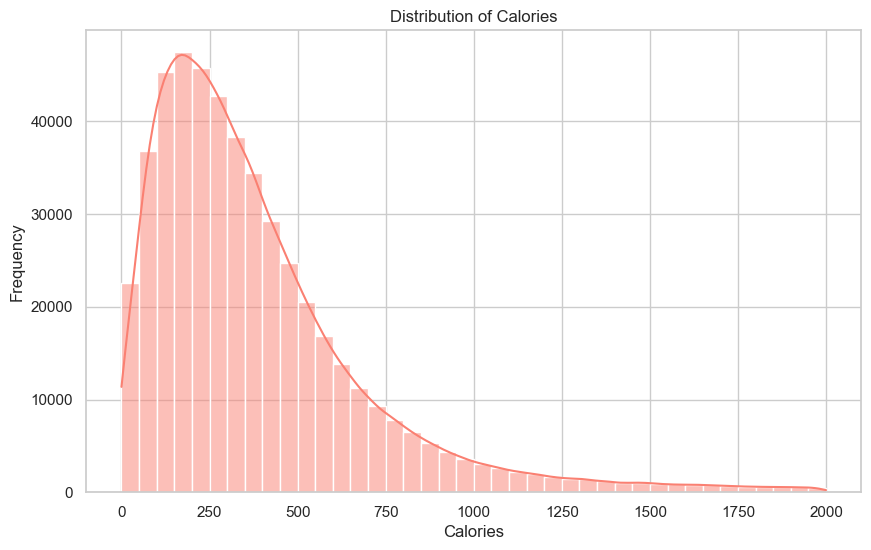

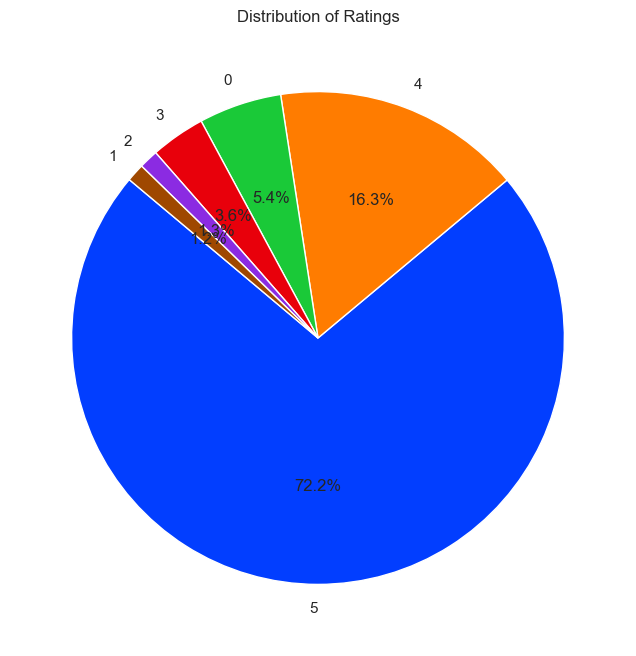

In [127]:
# Set the color palette
palette_color = sns.color_palette('bright')
sns.set_palette(palette_color)

# Nutritional content (Calories) visualization
plt.figure(figsize=(10, 6))
sns.histplot(recipes_df['Calories'][recipes_df['Calories'] < 2000], bins=40, kde=True, color='salmon')
plt.title('Distribution of Calories')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.show()

# Count the occurrences of each rating
ratings_count = reviews_df['Rating'].value_counts()

# Generate a colorful pie chart for the ratings distribution
plt.figure(figsize=(8, 8))
plt.pie(ratings_count, labels=ratings_count.index, autopct='%1.1f%%', startangle=140, colors=palette_color)
plt.title('Distribution of Ratings')
plt.show()

### Feature Engineering

In [128]:
# Difficulty level based on TotalTime (example logic, adjust as needed)
recipes_df['DifficultyLevel'] = pd.cut(recipes_df['TotalTimeMin'], 
                                       bins=[0, 60, 120, 180, float('inf')], 
                                       labels=['Easy', 'Medium', 'Hard', 'Very Hard'])

# Healthiness score based on nutritional content (simplified example)
recipes_df['HealthScore'] = (recipes_df['ProteinContent'] - recipes_df['FatContent']) / recipes_df['Calories']

In [129]:
# Display updated DataFrame
recipes_df.head()

,RecipeId,Name,AuthorId,AuthorName,DatePublished,Description,Images,RecipeCategory,Keywords,RecipeIngredientQuantities,...,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions,CookTimeMin,PrepTimeMin,TotalTimeMin,DifficultyLevel,HealthScore
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",Frozen Desserts,"c(""Dessert"", ""Low Protein"", ""Low Cholesterol"",...","c(""4"", ""1/4"", ""1"", ""1"")",...,30.2,3.2,4.0,Varies,"c(""Toss 2 cups berries with sugar."", ""Let stan...",1440.0,45,1485,Very Hard,0.004096
1,39,Biryani,1567,elly9812,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",Chicken Breast,"c(""Chicken Thigh & Leg"", ""Chicken"", ""Poultry"",...","c(""1"", ""4"", ""2"", ""2"", ""8"", ""1/4"", ""8"", ""1/2"", ...",...,20.4,63.4,6.0,Varies,"c(""Soak saffron in warm milk for 5 minutes and...",25.0,240,265,Very Hard,0.004142
2,40,Best Lemonade,1566,Stephen Little,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",Beverages,"c(""Low Protein"", ""Low Cholesterol"", ""Healthy"",...","c(""1 1/2"", ""1"", NA, ""1 1/2"", NA, ""3/4"")",...,77.2,0.3,4.0,Varies,"c(""Into a 1 quart Jar with tight fitting lid, ...",5.0,30,35,Easy,0.000321
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",Soy/Tofu,"c(""Beans"", ""Vegetable"", ""Low Cholesterol"", ""We...","c(""12"", ""1"", ""2"", ""1"", ""10"", ""1"", ""3"", ""2"", ""2...",...,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc...",20.0,1440,1460,Very Hard,0.009886
4,42,Cabbage Soup,1538,Duckie067,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",Vegetable,"c(""Low Protein"", ""Vegan"", ""Low Cholesterol"", ""...","c(""46"", ""4"", ""1"", ""2"", ""1"")",...,17.7,4.3,4.0,Varies,"c(""Mix everything together and bring to a boil...",30.0,20,50,Easy,0.037645
